In [418]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

def load_data(file_path="Data/salary_hours.xlsx"):
    df = pd.read_excel(file_path, skiprows=2, index_col=0)
    return {
        "Man": df.iloc[:-3, 1].values,
        "Woman": df.iloc[:-3, 4].values
    }, {
        "Man": df.iloc[:-3, 2].values,
        "Woman": df.iloc[:-3, 5].values
    }, {
        "Man": df.iloc[:-3, 3].values,
        "Woman": df.iloc[:-3, 6].values
    }



def sum_hours(t, man_yearly_hours, delta):
    total = 0
    for i in range(t):
        total += (1 - delta) ** i * man_yearly_hours[t - i]
    return total

def objective_function(params, hourly_salary, man_yearly_hours):
    w, beta1, beta2, delta, k0 = params
    total_error = 0
    for t in range(len(hourly_salary)):
        error = (
            np.log(hourly_salary[t])
            - np.log(w)
            - beta1 * ((1 - delta) ** t * k0 + sum_hours(t, man_yearly_hours, delta))
            - beta2 * ((1 - delta) ** t * k0 + sum_hours(t, man_yearly_hours, delta))**2
        )
        total_error += error ** 2
    return total_error

yearly_hours, yearly_salary, hourly_salary = load_data()

generated_hourly_salary_man = yearly_salary["Man"] / yearly_hours["Man"]

normalized_hours = yearly_hours["Man"] / 1924

initial_guess = [200, 0.02, -0.001, 0.05, 100]
bounds = [(0.001, 300), (0, 100), (-10, 0), (0, 0.1), (0, 300)]

def random_initial_guess(bounds):
    # np.random.seed(1)
    return [np.random.uniform(low, high) for low, high in bounds]


# initial_guess = random_initial_guess(bounds)


result = minimize(
    objective_function,
    x0=initial_guess,
    args=(generated_hourly_salary_man, normalized_hours),
    method="Nelder-Mead",
    bounds=bounds,
    tol=1e-12,
    options={
        "maxiter": 100000,  # Maximum iterations
        "xatol": 1e-12,
        "fatol": 1e-12, 
        "disp": True
    }
)


estimated_params = result.x
w_est, beta1_est, beta2_est, delta_est, k0_est = estimated_params

results_dict = {
    "Parameter": ["w", "beta1", "beta2", "delta", "k0"],
    "Estimated Value": [w_est, beta1_est, beta2_est, delta_est, k0_est],
}

results_df = pd.DataFrame(results_dict)

print(results_df)

print(result.fun)

Optimization terminated successfully.
         Current function value: 0.000171
         Iterations: 413
         Function evaluations: 757
  Parameter  Estimated Value
0         w       215.033648
1     beta1         0.030682
2     beta2        -0.001128
3     delta         0.016804
4        k0         0.000000
0.00017142616657019237


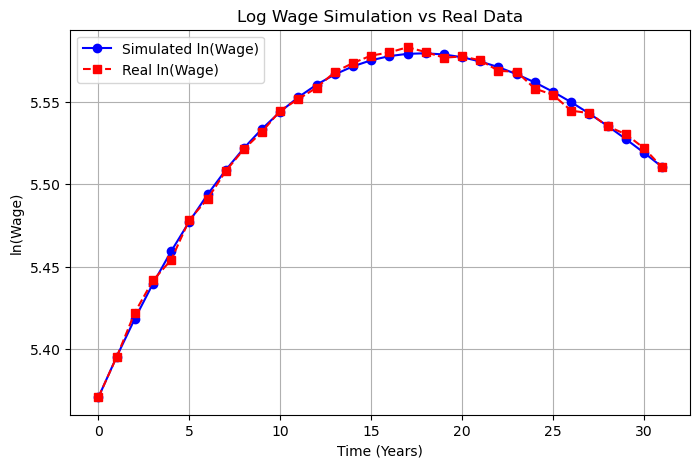

In [419]:
def simulate(params, man_hourly_salary, man_yearly_hours):
    w, beta1, beta2, delta, k0 = params
    ln_wage = np.zeros(len(man_hourly_salary))
    for t in range(len(man_hourly_salary)):
        ln_wage[t] = (
            np.log(w)
            + beta1 * ((1 - delta) ** t * k0 + sum_hours(t, man_yearly_hours, delta))
            + beta2 * ((1 - delta) ** t * k0 + sum_hours(t, man_yearly_hours, delta))**2
        )

    return ln_wage


ln_wage = simulate(estimated_params, hourly_salary["Man"], normalized_hours)


import matplotlib.pyplot as plt

def plot_ln_wage(ln_wage, man_hourly_salary, title="Log Wage Simulation vs Real Data", 
                 xlabel="Time (Years)", ylabel="ln(Wage)"):
    plt.figure(figsize=(8, 5))
    
    # Convert real hourly salary to log scale for comparison
    ln_real_wage = np.log(man_hourly_salary)
    
    # Plot simulated ln_wage
    plt.plot(ln_wage, marker="o", linestyle="-", label="Simulated ln(Wage)", color='b')
    
    # Plot real ln(wage)
    plt.plot(ln_real_wage, marker="s", linestyle="--", label="Real ln(Wage)", color='r')
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
plot_ln_wage(ln_wage, generated_hourly_salary_man)